DIA2
ZHAOJUN GUO&
MUCHAN DENG




In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator

# Open the data from Google drive

Because of the volume of the data,it is difficult to open directely,so we uploaded to our drive.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Openfood/"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['openfoodfacts.csv']

In [ ]:
import pandas as pd
openfoods=pd.read_csv("openfoodfacts.csv",sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,8,13,27,28,29,31,52,55,64,66) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data cleaning

This is a dataset of food products listing the ingredients and nutritional facts ( _100g) of more than 300,000 foods from over 150 countries in the world.
The data is meant to be free to the public to help users decode food labels, and make better food choices in general.
The dataset contains more than 300,000 rows over 163 columns. However, as we will see there are a lot of missing or obviously incorrect values.
- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
- fields that end with _tags are comma-separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutrient (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutrient (in g, or kJ for energy) for 1 serving of the product

- nutrition-score-fr_100g : experimental nutrition score derived from the UK FSA score and adapted for the French market (these fields are of numeric, ranging from -15 to 40. The lower the score, the better)
- nutrition-score-uk_100g : nutrition score defined by the UK Food Standards Administration (these fields are of numeric, ranging from -15 to 40. The lower the score, the better)
- nutrition_grade_fr_100g : Seems to be a simple categorization of the score into A, B, C, D, and E (The UK equivalent contains mostly NaNs)

In [ ]:
print("This data is really messy! \nthe 'countries_en' column contians {} \"unique\" countries ".format(openfoods['countries_en'].dropna().unique().shape[0]))

This data is really messy! 
the 'countries_en' column contians 4301 "unique" countries 


In [ ]:
openfoods.isnull().sum().sort_values()

code                                 0
url                                  0
created_t                            0
created_datetime                     0
last_modified_t                      0
                                ...   
-eicosapentaenoic-acid_100g    2013584
-alpha-linolenic-acid_100g     2013584
-melissic-acid_100g            2013584
-elaidic-acid_100g             2013584
-montanic-acid_100g            2013584
Length: 187, dtype: int64

In [ ]:
openfoods.countries.value_counts().head(10)

France           435195
United States    310605
en:fr            207754
en:es            104001
en:it             96762
España            86818
en:france         76436
en:us             45009
en:be             33622
en:ca             28276
Name: countries, dtype: int64

In [ ]:
openfoods_us=openfoods[(openfoods['countries']=='United States')|(openfoods['countries']=='en:us')]


In [ ]:
nutrition_table_cols = ["product_name","categories","ingredients_text","fat_100g", "carbohydrates_100g", "sugars_100g", "proteins_100g", "salt_100g", "energy_100g"]
new_openfoods = openfoods_us[nutrition_table_cols].copy()

In [ ]:
# drop all rows that (after dropping some columns) only contain NaNs
new_openfoods = new_openfoods.dropna(axis=0, how='all') 

In [ ]:
new_openfoods['product_name'].fillna(value='Product name unavailable', inplace=True)

In [ ]:
# We check whether there are any duplicates in our data (this excludes out index-column)
new_openfoods.duplicated().sum()

14395

In [ ]:
# We drop all duplicates from our data
new_openfoods.drop_duplicates(inplace=True)

In [ ]:
new_openfoods.isnull().sum().sort_values()

product_name              0
fat_100g               7555
carbohydrates_100g     7866
proteins_100g          7990
energy_100g            8144
salt_100g             13580
sugars_100g           20781
ingredients_text      45656
categories            69302
dtype: int64

In [ ]:
new_openfoods=new_openfoods.dropna()

In [ ]:
new_openfoods.isnull().sum().sort_values()

product_name          0
categories            0
ingredients_text      0
fat_100g              0
carbohydrates_100g    0
sugars_100g           0
proteins_100g         0
salt_100g             0
energy_100g           0
dtype: int64

In [ ]:
len(new_openfoods)

252265

So we have finished the data cleaning and we begin to do the processing of the ingredient vocabulary

# Processing the ingredient vocabulary

In [ ]:
ingredient=new_openfoods['ingredients_text']

In [ ]:
ingredient

287                       Cranberries, sugar, sunflower oil.
531        Unbleached enriched flour (wheat flour, barley...
535        Wheatflour, sugar, eggs, soybean oil, water, c...
541        Pastry: unbleached wheat flour (wheat flour, m...
818        Canola oil, Water, Palm oil, Palm kernel oil, ...
                                 ...                        
2010240    milk**, sugar, cocoa butter, cocoa mass, veget...
2010593    Concentrated grape-juice, balsamic vinegar of ...
2010634            ORGANIC GROUND rbohydrate 10q Fiber 2g 3%
2011947                                             Cassava.
2013312    Organic almondmilk (filtered water, organic al...
Name: ingredients_text, Length: 252265, dtype: object

In [ ]:
ingredient=list(ingredient.values)
len(ingredient)

252265


1) Define and clean the vocabulary of ingredients, do you find some mistakes ? How do you manage them ? Propose solutions to manage/identify errors.

In [ ]:
import re
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
nltk.download('punkt')
tokenizer=nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer_output=WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We want to delete the english number after the tokenizer,but the type of the number is string,for exemple:"1.6"

In [ ]:
def is_number(s):
    try:  # return true if can execute float(s)
        float(s)
        return True
    except ValueError:  
        pass  
    try:
        import unicodedata  # package of ASCii processing
        unicodedata.numeric(s)  # convert a string typed number to a float
        return True
    except (TypeError, ValueError):
        pass
    return False

In this dataset,there is not only the english,but also a few of French,so there will be have the number like:"1,7",so we decide to clean after we do the tokenizer

In [ ]:
'''
def sub_france_number(sweet):
  for i in range(len(sweet)):
    word=re.sub(r'(\d{1,3}(?:(?:[. \u00A0])?\d{3})*(?:,\d+)?(?!\d))','',sweet[i])
    sweet[i]=word  
  return sweet
  '''

In [ ]:
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    tweet = re.sub(r'[z0-9]','', tweet)
    # only removing the hash # %sign from the word
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'%', '', tweet)
    tweet = re.sub(r'&', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    punctuation = '!,;:?"\'、，；)(.'
#    tweet_tokens=tweet.split(',')
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation and is_number(word)==False):  
                # remove punctuation 
                #remove englidh numbers
            # tweets_clean.append(word)
            text_word=lemmatizer_output.lemmatize(word)
            stem_word = stemmer.stem(word)
            stem_word = re.sub(r'[{}]+'.format(punctuation),'',stem_word)  # stemming word
            tweets_clean.append(stem_word)
# remove frenche number    
#    tweets_clean=sub_france_number(tweets_clean)
    
#remove the duplicate
    tweets_clean=list(set(tweets_clean))

    return tweets_clean

In [ ]:
new_ingredient=[]
for i in range(len(ingredient)):
  process=process_tweet(ingredient[i])
  new_ingredient.append(process)

In [ ]:
import nltk
vocabulary = nltk.FreqDist()

In [ ]:
# This was done once I had already preprocessed the ingredients
new_list=[]
for ingredients in new_ingredient:
    for i in ingredients:
      new_list.append(i)
    vocabulary.update(ingredients)
for word, frequency in vocabulary.most_common(200):
    print(f'{word};{frequency}')

salt;164693
sugar;136679
flavor;125264
water;117743
acid;115598
oil;113077
natur;110068
corn;91625
milk;79667
flour;70314
syrup;68191
citric;67288
sodium;67211
color;66312
wheat;63561
starch;59055
soy;57015
gum;56031
less;54593
powder;54033
contain;53878
soybean;50797
lecithin;47600
artifici;46272
garlic;46121
spice;45531
extract;44560
thiamin;43764
folic;43065
onion;43013
riboflavin;42447
cultur;42426
juic;41060
mononitr;40925
red;40866
phosphat;39999
iron;39675
niacin;39488
veget;38746
calcium;37867
modifi;36693
palm;36331
preserv;36289
concentr;36150
enrich;35410
vinegar;34601
yeast;34012
potassium;33523
vitamin;33358
enym;33304
canola;32738
butter;32709
pepper;32173
whey;31880
dextros;31611
sea;31170
cocoa;31039
reduc;30507
cream;29433
dri;29002
xanthan;28992
pasteuri;28987
yellow;28890
organ;28775
whole;27617
egg;27548
sunflow;27547
chees;26970
tomato;24728
bean;24288
maltodextrin;24264
cane;24101
fructos;24085
ascorb;23855
white;23665
high;23256
rice;22948
nonfat;22795
protein;22

We can find that there is some word isn't be well 
process

In [ ]:
def ingredient_parser(ingredients):
    # measures and common words (already lemmatized)   
    measures = ['fdc','ad','follow','brown','mono','high','white','dri','ad','less','green','et','red','yellow','color','blue','black']
    ingred_list = []
    for word in ingredients:
      if word not in measures:
        ingred_list.append(word)
    return ingred_list

In [ ]:
for i in range(len(new_ingredient)):
  new_ingredient[i]=ingredient_parser(new_ingredient[i])

In [ ]:
len(new_ingredient)

252265

# Another Obvious mistake

Based on nutrition facts and/or food categories, propose clustering approaches and a visualisation of some categories of products. Find outliers (a product very different from others of the same group). It exists products very similars in terms of nutrition facts but very different in terms of categories or ingredients ?

In [ ]:
new_openfoods.ingredients_text=new_ingredient

In [ ]:
new_openfoods.head(10)

,product_name,categories,ingredients_text,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g
287,Cranberries,"Plant-based foods and beverages, Plant-based f...","[sunflow, oil, cranberri, sugar]",0.00,83.33,66.67,0.00,0.00000,1255.0
531,Sliced Plain Bagel,"Plant-based foods and beverages, Plant-based f...","[folic, malt, wheat, iron, salt, yeast, gluten...",1.18,71.76,4.71,12.94,1.19634,1527.0
535,Muffin,"Snacks, Sweet snacks, Biscuits and cakes, Cake...","[soybean, alkali, oil, dairi, liquor, calcium,...",21.76,51.76,32.94,5.88,0.67310,1749.0
541,Apple Turnover,"Snacks, Sweet snacks, Viennoiseries, Apple tur...","[appl, folic, malt, wheat, iron, oil, salt, mo...",22.35,42.35,15.29,4.71,0.80772,1623.0
818,Original Buttery Spread,en:Fats,"[natur, oil, salt, vitamin, di-alpha-tocophero...",71.43,0.00,0.00,0.00,1.78500,2690.0
819,"Canola harvest, buttery spread, with flaxseed oil",Fats,"[soybean, oil, salt, vitamin, flax, sorbat, ca...",57.14,0.00,0.00,0.00,1.34000,2389.0
834,German fine bread,"Plant-based foods and beverages, Plant-based f...","[malt, seed, wheat, yeast, salt, whole, water,...",3.51,52.63,8.77,7.02,1.71000,1100.0
835,"Today's temptations, lithuanian rye bread","Plant-based foods and beverages, Plant-based f...","[onion, malt, seed, wheat, yeast, salt, water,...",2.63,47.37,8.77,5.26,1.40250,954.0
917,"Bakers Best, White Bread","Plant-based foods and beverages, Plant-based f...","[ada, soybean, cottonse, folic, malt, wheat, y...",1.47,50.00,5.88,8.82,1.25000,983.0
918,"Bakers Best, Rye Bread","Plant-based foods and beverages, Plant-based f...","[folic, malt, natur, wheat, yeast, oil, salt, ...",2.56,53.85,2.56,7.69,0.80250,1071.0


Reconstructing the energy
Now we have our cleaned data we really can work with! But before we start we want to look closer at the individual features. We know that the energy a product contains can mainly be calculated through his amount of carbs, fat and proteins. We also know the following: 1g of fat contains about 39 kJ of energy; 1g of carbohydrates and proteins both contain about 17 kJ of energy .

Because of the complicated input-process in the OpenFoodFacts app we already said that some users start to type in wrong values. The energy is also often given in kJ and kcal, so the users can get even more confused. By calculating the energy based on the features fat, carbohydrates and proteins and comparing it to the given value of energy we can detect if some entries might be wrong and could probably even correct them in some cases:

In [ ]:
new_openfoods['fat_100g']=abs(new_openfoods['fat_100g'])
new_openfoods['carbohydrates_100g']=abs(new_openfoods['carbohydrates_100g'])
new_openfoods['sugars_100g']=abs(new_openfoods['sugars_100g'])
new_openfoods['proteins_100g']=abs(new_openfoods['proteins_100g'])
new_openfoods['salt_100g']=abs(new_openfoods['salt_100g'])

In [ ]:
new_openfoods["reconstructed_energy"] = new_openfoods["fat_100g"] * 39 + new_openfoods["carbohydrates_100g"] * 17 + new_openfoods["proteins_100g"] * 17

In [ ]:
new_openfoods['reconstructed_energy']=abs(new_openfoods['reconstructed_energy'])

In [ ]:
max(new_openfoods.reconstructed_energy)

23868.0

In [ ]:
min(new_openfoods.reconstructed_energy)

0.0

In [ ]:
mistake=new_openfoods[new_openfoods['reconstructed_energy']>=10000]
mistake

,product_name,categories,ingredients_text,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy
222217,Creamy Peanut Butter,"Plant-based foods and beverages,Plant-based fo...","[seed, oil, salt, rapese, veget, cotton, peanu...",280.0,160.0,60.0,140.0,32.0,15100.0,16020.0
359879,Creamy Peanut Butter,"Plant-based foods and beverages,Plant-based fo...","[soybean, oil, salt, hydrogen, peanut, roast, ...",320.0,120.0,60.0,120.0,5.5,16700.0,16560.0
436163,Pure Irish Butter Unsalted,"Fats, en:butters","[cream, pasteuri, cultur, milk, skim]",612.0,0.0,0.0,0.0,0.0,21400.0,23868.0


In [ ]:
new_openfoods=new_openfoods.drop(index=mistake.index)

In [ ]:
max(new_openfoods["reconstructed_energy"])

6166.780000000001

In [ ]:
max(new_openfoods["energy_100g"])

11188.0

In [ ]:
mistake2=new_openfoods[new_openfoods['energy_100g']>=10000]
mistake2

,product_name,categories,ingredients_text,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy
4245,Orange dark chocolate truffles,"Snacks, Sweet snacks, Confectioneries, Chocola...","[natur, oil, butter, skim, soya, coconut, milk...",52.78,41.67,36.11,5.56,0.075,11188.0,2861.33


In [ ]:
new_openfoods=new_openfoods.drop(index=mistake2.index)

It seems like the reconstructed energy is almost matching the given amout of energy. But let's look at a plot of both amounts of energy for a better conclusion:

([<matplotlib.axis.YTick at 0x7f2e48c79890>,
 <a list of 9 Text major ticklabel objects>)

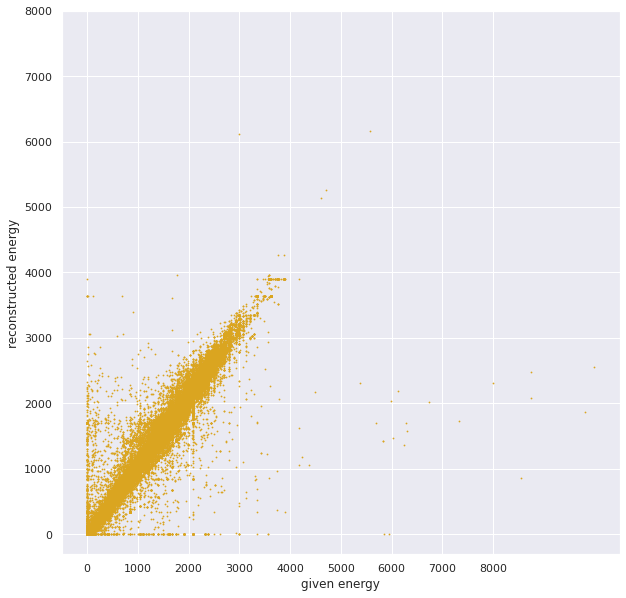

In [ ]:
plt.figure(figsize = (10,10))
plt.scatter(new_openfoods["energy_100g"], new_openfoods["reconstructed_energy"], s = 0.6, c= "goldenrod")
plt.xlabel("given energy")
plt.ylabel("reconstructed energy")
my_x_ticks = np.arange(0, 9000, 1000)
my_y_ticks = np.arange(0, 9000, 1000)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)

Another obvious mistake

Apart from the mistakes we detected through our reconstructed energy we can also easily detect another mistake: Our features fat, carbohydrates and proteins are given based on 100g. So if the sum of these features is higher than 100 we would also know that there is something wrong with our given data.

So let's see if we can find any of these mistakes:

In [ ]:
new_openfoods["g_sum"] = new_openfoods.fat_100g + new_openfoods.carbohydrates_100g + new_openfoods.proteins_100g

new_openfoods["exceeded"] = np.where(new_openfoods.g_sum.values > 100, 1, 0)
new_openfoods[new_openfoods["exceeded"] == 1].head()

,product_name,categories,ingredients_text,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy,g_sum,exceeded
3393,"Meiji, hello panda, choco biscuits with choco ...","Snacks, Sweet snacks, Biscuits and cakes, Bisc...","[wheat, oil, cream, salt, yeast, mass, butter,...",26.67,66.67,26.67,6.67,0.8325,2230.0,2286.91,100.01,1
3395,Biscuit,"Snacks, Sweet snacks, Biscuits and cakes, Bisc...","[leav, malt, natur, wheat, oil, salt, bean, ci...",26.67,66.67,26.67,6.67,0.9175,2230.0,2286.91,100.01,1
3396,Biscuits,"Snacks, Sweet snacks, Biscuits and cakes, Bisc...","[malt, natur, wheat, oil, salt, skim, canola, ...",26.67,66.67,33.33,6.67,0.9175,2230.0,2286.91,100.01,1
3662,Peanut butter cup optimal low-carb ketogenic n...,"Snacks, Sweet snacks, Confectioneries","[natur, oil, salt, vanilla, butter, isol, coat...",47.06,41.18,5.88,11.76,0.2200,2213.0,2735.32,100.00,1
3663,Peanut butter cup fat bomb snack,Snacks,"[natur, oil, salt, vanilla, butter, isol, coat...",47.06,41.18,5.88,11.76,0.2200,2213.0,2735.32,100.00,1


In [ ]:
new_openfoods.exceeded.value_counts()

0    250841
1      1420
Name: exceeded, dtype: int64

In [ ]:
exceeded=new_openfoods[new_openfoods.exceeded==1]
exceeded

,product_name,categories,ingredients_text,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy,g_sum,exceeded
3393,"Meiji, hello panda, choco biscuits with choco ...","Snacks, Sweet snacks, Biscuits and cakes, Bisc...","[wheat, oil, cream, salt, yeast, mass, butter,...",26.67,66.67,26.67,6.67,0.8325,2230.0,2286.91,100.01,1
3395,Biscuit,"Snacks, Sweet snacks, Biscuits and cakes, Bisc...","[leav, malt, natur, wheat, oil, salt, bean, ci...",26.67,66.67,26.67,6.67,0.9175,2230.0,2286.91,100.01,1
3396,Biscuits,"Snacks, Sweet snacks, Biscuits and cakes, Bisc...","[malt, natur, wheat, oil, salt, skim, canola, ...",26.67,66.67,33.33,6.67,0.9175,2230.0,2286.91,100.01,1
3662,Peanut butter cup optimal low-carb ketogenic n...,"Snacks, Sweet snacks, Confectioneries","[natur, oil, salt, vanilla, butter, isol, coat...",47.06,41.18,5.88,11.76,0.2200,2213.0,2735.32,100.00,1
3663,Peanut butter cup fat bomb snack,Snacks,"[natur, oil, salt, vanilla, butter, isol, coat...",47.06,41.18,5.88,11.76,0.2200,2213.0,2735.32,100.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1972733,"Sobisk, mini snak salted cracker",Biscuits and cakes,"[wheat, oil, salt, liquid, yeast, bicarbon, fl...",21.43,71.43,7.14,7.14,1.7850,2092.0,2171.46,100.00,1
1973878,Cumin seed whole organic spices,"Plant-based foods and beverages, Plant-based f...","[seed, cumin, whole]",30.95,47.62,0.00,23.81,0.0000,1992.0,2421.36,102.38,1
1973879,Cumin seed ground organic spices,"Plant-based foods and beverages, Plant-based f...","[seed, cumin, ground]",30.95,47.62,0.00,23.81,0.0000,1992.0,2421.36,102.38,1
1973898,White pepper ground organic spices,"Plant-based foods and beverages, Plant-based f...","[peppercorn, ground]",0.00,83.33,0.00,20.83,0.0000,870.0,1770.72,104.16,1


In [ ]:
new_openfoods=new_openfoods.drop(index=exceeded.index)

# Clusering

In [ ]:
new_openfoods.categories.value_counts()

Snacks                                                                                                                                                                                                                                                                 29762
Snacks, Sweet snacks, Confectioneries                                                                                                                                                                                                                                  12603
Groceries, Sauces                                                                                                                                                                                                                                                      11525
Dairies, Fermented foods, Fermented milk products, Cheeses                                                                                                                                       

We can find the columns of categories is very messy,so we decide to do some cleaning







In [ ]:
new_openfoods.categories.value_counts().head(50)

Snacks                                                                                                                                                                      29762
Snacks, Sweet snacks, Confectioneries                                                                                                                                       12603
Groceries, Sauces                                                                                                                                                           11525
Dairies, Fermented foods, Fermented milk products, Cheeses                                                                                                                  10110
Desserts, Frozen foods, Frozen desserts                                                                                                                                      8859
Snacks, Sweet snacks, Biscuits and cakes, Biscuits                                                            

In [ ]:
Snack=['Biscuits and cakes, Pastries','Biscuits and cakes, Cakes, Cooking helpers, Dessert mixes, Pastry helpers, Cake mixes','Baking decorations','Biscuits and cakes','Salted snacks','Snacks, Sweet snacks, Confectioneries, Chocolate candies','Biscuits and cakes, Cakes','Snacks','Snacks, Sweet snacks, Confectioneries','Snacks, Sweet snacks, Biscuits and cakes, Biscuits']
Sauce=['Groceries, Sauces','Groceries, Sauces, Dips','Groceries, Condiments']
Cheese=['Dairies, Fermented foods, Fermented milk products, Cheeses']
Dessert=['Desserts, Frozen foods, Frozen desserts']
Frozen_food=['Frozen foods']
Drinks=['Beverages, Iced teas','Beverages, Waters','Beverages, Carbonated drinks, Sodas','Beverages']
Yagurt=['Dairies, Fermented foods, Fermented milk products, Yogurts']
Meats=['Meats, Frozen foods, Frozen meats','Meats, Prepared meats','Meats, Prepared meats, Sausages']
Pizza=['Meals, Pizzas pies and quiches, Pizzas']
Soup=['Meals, Soups','Canned foods, Meals, Soups, Canned meals, Canned soups']
Milk=['Dairies, Milks']
Vegetables=['Canned legumes, Canned common beans']
Seafood=['Seafood, Frozen seafood','Seafood']

In [ ]:
def change_product_name(a):
  if a in Snack:
    return 'Snack'
  elif a in Meat:
    return 'Meat'
  elif a in Drinks:
    return 'Drinks'
  elif a in Milk:
    return 'Milk'
  elif a in Yagurt:
    return 'Yagurk'
  elif a in Desserts:
    return 'Desserts'
  elif a in Vegetables:
    return 'Vegetables'
  elif a in Cheese:
    return 'Cheese'
  elif a in Pizza:
    return 'Pizza'
  elif a in Soap:
    return 'Soap'
  elif a in Seafood:
    return 'Seafood'
  else:
    return 'Other'

In [ ]:
x=new_openfoods.apply(lambda x: change_product_name(x['categories']), axis=1)

In [ ]:
new_openfoods.categories=x

In [ ]:
new_openfoods=new_openfoods[new_openfoods.categories!='Other']
new_openfoods.head()

,product_name,categories,ingredients_text,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy,g_sum,exceeded
939,"Piasten, Chocolate Assortment",Snack,"[wheat, oil, min, humect, mass, butter, citric...",26.25,58.75,6.5,8.75,0.0300,2029.0,2171.25,93.75,0
948,"Nestle, dark truffles grand chocolate",Snack,"[sunflow, alkali, butter, miner, sorbitol, mil...",35.00,50.00,35.0,5.00,0.1250,1987.0,2300.00,90.00,0
953,"Mt. olive, sweet 'n' hot salad peppers",Snack,"[banana, natur, salt, calcium, vinegar, benoat...",0.00,32.14,25.0,0.00,1.6075,598.0,546.38,32.14,0
980,"Ritter sport, knusperflakes mit knusprigen cor...",Snack,"[mass, malt, lactos, natur, cream, salt, cocoa...",28.00,60.00,49.6,8.00,0.4000,2209.0,2248.00,96.00,0
990,"Funsch, High Quality Marzipan",Snack,"[almond, carmin, invert, food, water, sorbitol...",21.40,55.20,51.6,9.60,0.2500,1929.0,1936.20,86.20,0


In [ ]:
features = ["fat_100g", "carbohydrates_100g", "sugars_100g", "proteins_100g", "salt_100g", "energy_100g", "reconstructed_energy", "g_sum"]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
#from sklearn import datasets
from sklearn.datasets import load_iris

X_train = new_openfoods[features].values

model = KMeans(n_clusters=11,random_state=42)
model.fit(X_train)
results = new_openfoods.copy()
results["cluster"] = model.predict(X_train)

In [ ]:
results.head(10)

,product_name,categories,ingredients_text,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy,g_sum,exceeded,cluster
939,"Piasten, Chocolate Assortment",Snack,"[wheat, oil, min, humect, mass, butter, citric...",26.25,58.75,6.50,8.75,0.0300,2029.0,2171.25,93.75,0,2
948,"Nestle, dark truffles grand chocolate",Snack,"[sunflow, alkali, butter, miner, sorbitol, mil...",35.00,50.00,35.00,5.00,0.1250,1987.0,2300.00,90.00,0,2
953,"Mt. olive, sweet 'n' hot salad peppers",Snack,"[banana, natur, salt, calcium, vinegar, benoat...",0.00,32.14,25.00,0.00,1.6075,598.0,546.38,32.14,0,5
980,"Ritter sport, knusperflakes mit knusprigen cor...",Snack,"[mass, malt, lactos, natur, cream, salt, cocoa...",28.00,60.00,49.60,8.00,0.4000,2209.0,2248.00,96.00,0,2
990,"Funsch, High Quality Marzipan",Snack,"[almond, carmin, invert, food, water, sorbitol...",21.40,55.20,51.60,9.60,0.2500,1929.0,1936.20,86.20,0,6
991,Oatmeal Raisin Cookies,Snack,"[sugar, raisin, madagascar, cut, steel, oat, c...",21.43,67.86,28.57,7.14,0.5350,1552.0,2110.77,96.43,0,6
992,The Best Peanut Butter Cookies,Snack,"[sugar, whole, un-bleach, un-refin, butter, pe...",21.43,67.86,28.57,7.14,0.5350,1703.0,2110.77,96.43,0,6
993,Best Sweet-Potato Cookies,Snack,"[sweet, proprietari, cranberri, bake, butter, ...",17.65,50.00,17.65,2.94,0.3675,1623.0,1588.33,70.59,0,10
994,Best Ginger Snap Cookies,Snack,"[ginger, salt, molass, butter, flour, judy, gr...",17.65,50.00,17.65,2.94,0.3675,1623.0,1588.33,70.59,0,10
998,"Lactaid, ice cream, vanilla",Desserts,"[enym, guar, syrup, natur, lactas, gum, cream,...",11.27,22.54,16.90,2.82,0.1400,883.0,870.65,36.63,0,3


In [ ]:
results.cluster.value_counts()

10    18690
7     14848
0     14697
6     14278
2     13756
1     12217
8     11021
3     10881
9      7191
5      7059
4      1753
Name: cluster, dtype: int64

In [ ]:
cluster_10=results[results.cluster==10]
cluster_10.head(10)

,product_name,categories,ingredients_text,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy,g_sum,exceeded,cluster
993,Best Sweet-Potato Cookies,Snack,"[sweet, proprietari, cranberri, bake, butter, ...",17.65,50.00,17.65,2.94,0.3675,1623.0,1588.33,70.59,0,10
994,Best Ginger Snap Cookies,Snack,"[ginger, salt, molass, butter, flour, judy, gr...",17.65,50.00,17.65,2.94,0.3675,1623.0,1588.33,70.59,0,10
1274,"Candy crush, sugar crush crunchy and crackling...",Snack,"[natur, caramin, carbon, wax, candi, flavor, m...",0.00,100.00,90.00,0.00,0.0250,1674.0,1700.00,100.00,0,10
1310,"Welch's, golden apple chips",Snack,"[fresh, appl, preserv, sulphit, sodium]",0.00,92.86,78.57,0.00,1.6075,1644.0,1578.62,92.86,0,10
1312,Green apple chips,Snack,"[natur, appl, flavor]",0.00,92.86,75.00,0.00,0.0000,1644.0,1578.62,92.86,0,10
1447,Brownie mix,Snack,"[soybean, alkali, cottonse, folic, wheat, iron...",3.85,82.05,46.15,7.69,0.9625,1611.0,1675.73,93.59,0,10
1456,Biscuit mix,Snack,"[soybean, folic, malt, wheat, iron, oil, salt,...",16.67,54.76,4.76,11.90,1.4875,1795.0,1783.35,83.33,0,10
1462,Soup mix,Soap,"[oil, lactic, salt, yeast, cultur, phosphat, m...",15.22,60.87,17.39,8.70,5.3250,1728.0,1776.27,84.79,0,10
2858,"Specialita le italiane, hard filled candy",Snack,"[sugar, pgi, orang, juic, sicili, acid, natur,...",0.00,92.86,78.57,0.00,0.0000,1795.0,1578.62,92.86,0,10
3441,"Old-fashioned glazed dunkers, glazed",Snack,"[soybean, folic, malt, natur, wheat, iron, oil...",16.22,56.76,32.43,2.70,1.0125,1582.0,1643.40,75.68,0,10


In [ ]:
cluster_10.categories.value_counts()

Snack       14514
Cheese       3332
Meat          307
Drinks        238
Desserts      180
Soap           89
Milk           18
Pizza           5
Seafood         5
Yagurk          2
Name: categories, dtype: int64

For exemple this is the outlier

In [ ]:
cluster_7[cluster_7.categories=='Yagurk']

,product_name,categories,ingredients_text,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy,g_sum,exceeded,cluster,certainty
257346,Strawberry parfait,Yagurk,"[guar, oil, phosphat, starch, juic, fat, flavo...",11.538462,46.153846,33.333333,2.564103,0.833333,1287.0,1278.205128,60.256410,0,7,0.51
349639,Chewy chocolate chip,Yagurk,"[cherri, guar, natur, hibiscus-carrot, bean, c...",14.583333,70.833333,29.166667,4.166667,0.729167,1743.0,1843.750000,89.583333,0,7,1.00
389258,Chocolate mousse,Yagurk,"[guar, oil, cream, liquor, calcium, cellulos, ...",25.330000,46.670000,36.000000,2.670000,0.632500,1841.0,1826.650000,74.670000,0,7,0.99


# Visualisation

In [ ]:
new_openfoods.head()

,product_name,categories,ingredients_text,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,energy_100g,reconstructed_energy,g_sum,exceeded
939,"Piasten, Chocolate Assortment",Snack,"[wheat, oil, min, humect, mass, butter, citric...",26.25,58.75,6.5,8.75,0.0300,2029.0,2171.25,93.75,0
948,"Nestle, dark truffles grand chocolate",Snack,"[sunflow, alkali, butter, miner, sorbitol, mil...",35.00,50.00,35.0,5.00,0.1250,1987.0,2300.00,90.00,0
953,"Mt. olive, sweet 'n' hot salad peppers",Snack,"[banana, natur, salt, calcium, vinegar, benoat...",0.00,32.14,25.0,0.00,1.6075,598.0,546.38,32.14,0
980,"Ritter sport, knusperflakes mit knusprigen cor...",Snack,"[mass, malt, lactos, natur, cream, salt, cocoa...",28.00,60.00,49.6,8.00,0.4000,2209.0,2248.00,96.00,0
990,"Funsch, High Quality Marzipan",Snack,"[almond, carmin, invert, food, water, sorbitol...",21.40,55.20,51.6,9.60,0.2500,1929.0,1936.20,86.20,0


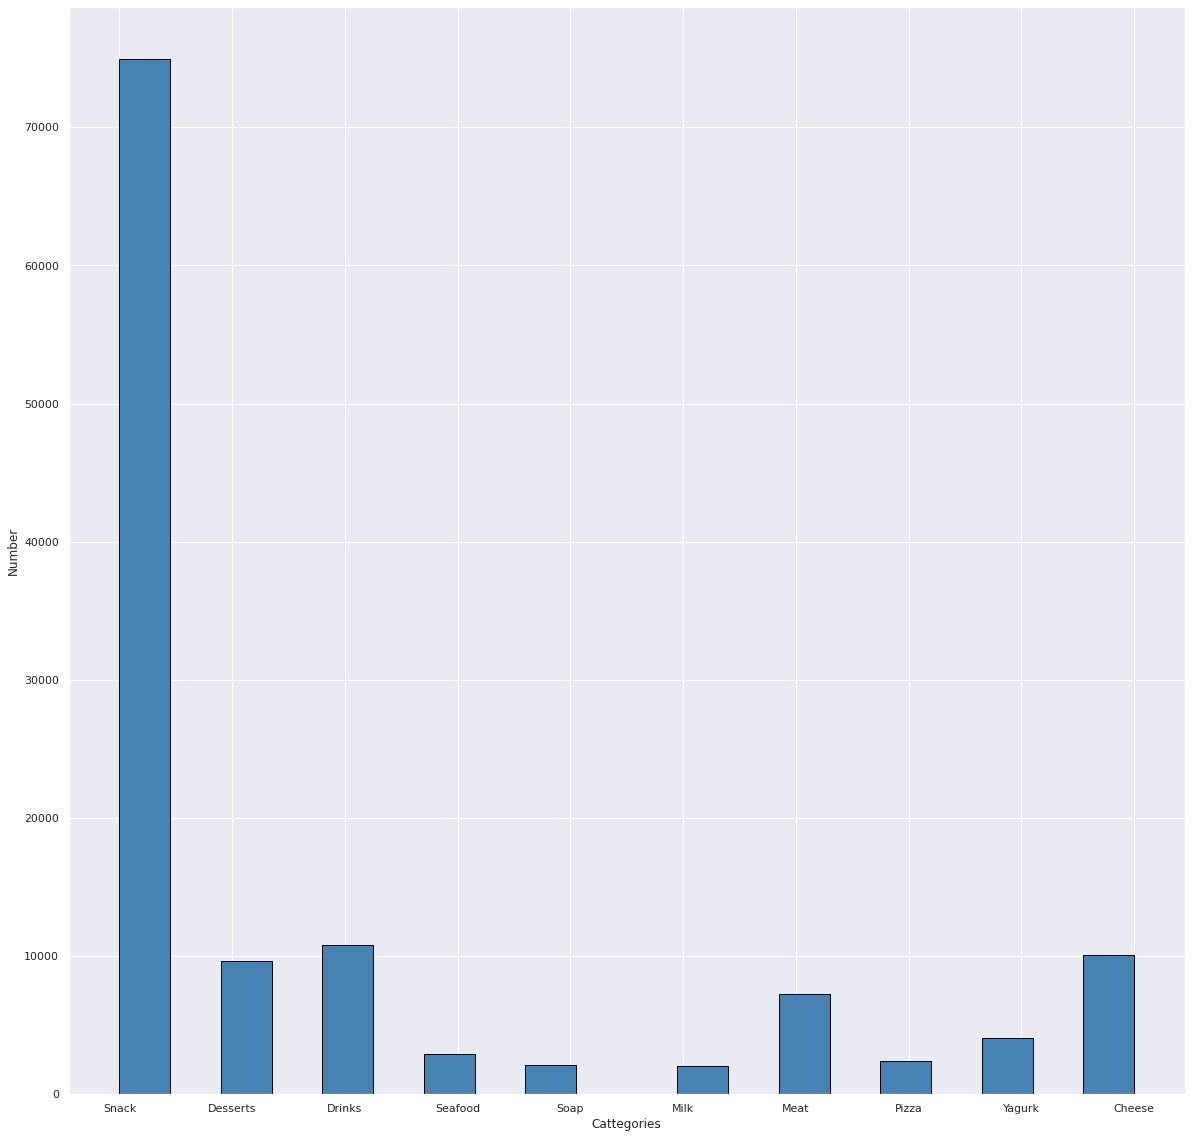

In [ ]:
plt.figure(figsize=(20, 20))
plt.hist(x=new_openfoods.categories,bins=20,
        color="steelblue",
        edgecolor="black")

#add x y labels
plt.xlabel("Cattegories")
plt.ylabel("Number")

#add title
plt.title("")

plt.show()
